<a href="https://colab.research.google.com/github/nishatlea/Facial-Keypoint-Detection/blob/main/Test%20Code%201%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
https://youtu.be/vC3bTziLRTA

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nipaanjum","key":"39b142e16804b1c15a20d2603d58bc5e"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
! kaggle datasets list

ref                                                               title                                                 size  lastUpdated          downloadCount  
----------------------------------------------------------------  --------------------------------------------------  ------  -------------------  -------------  
nehaprabhavalkar/indian-food-101                                  Indian Food 101                                        7KB  2020-09-30 06:23:43           4105  
christianlillelund/donald-trumps-rallies                          Donald Trump's Rallies                               720KB  2020-09-26 10:25:08           1016  
heeraldedhia/groceries-dataset                                    Groceries dataset                                    257KB  2020-09-17 04:36:08           4750  
andrewmvd/trip-advisor-hotel-reviews                              Trip Advisor Hotel Reviews                             5MB  2020-09-30 08:31:20           2786  
balraj98/stanford-back

In [ ]:
!kaggle competitions download -c facial-keypoints-detection

  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 79.2MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 120MB/s]
 82% 49.0M/60.1M [00:00<00:00, 54.5MB/s]
100% 60.1M/60.1M [00:00<00:00, 112MB/s] 
 31% 5.00M/16.0M [00:00<00:00, 22.0MB/s]
100% 16.0M/16.0M [00:00<00:00, 53.3MB/s]


In [ ]:
!unzip -q training.zip -d .

In [ ]:
!unzip -q test.zip -d .
!ls

drive		   sample_data		 test.zip
IdLookupTable.csv  SampleSubmission.csv  training.csv
kaggle.json	   test.csv		 training.zip


In [ ]:
#####  LOADING AND EXTRACTING DATA   #####


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle


def data_loader():
    
    # Load dataset file
    data_frame = pd.read_csv('training.csv')
    
    data_frame['Image'] = data_frame['Image'].apply(lambda i: np.fromstring(i, sep=' '))
    data_frame = data_frame.dropna()  # Get only the data with 15 keypoints
   
    # Extract Images pixel values
    imgs_array = np.vstack(data_frame['Image'].values)/ 255.0
    imgs_array = imgs_array.astype(np.float32)    # Normalize, target values to (0, 1)
    imgs_array = imgs_array.reshape(-1, 96, 96, 1)
        
    # Extract labels (key point cords)
    labels_array = data_frame[data_frame.columns[:-1]].values
    labels_array = (labels_array - 48) / 48    # Normalize, traget cordinates to (-1, 1)
    labels_array = labels_array.astype(np.float32) 
    
    # shuffle the train data
#     imgs_array, labels_array = shuffle(imgs_array, labels_array, random_state=9)  
    
    return imgs_array, labels_array

(2140, 96, 96, 1)
(2140, 30)


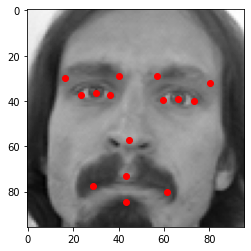

In [ ]:
# This snippet is just to check/verify data
imgs, labels = data_loader()
print(imgs.shape)
print(labels.shape)

n=0
labels[n] = (labels[n]*48)+48
image = np.squeeze(imgs[n])
plt.imshow(image, cmap='gray')
plt.plot(labels[n][::2], labels[n][1::2], 'ro')
plt.show()

In [ ]:
######   BUILD, TRAIN AND SAVE THE CONVOLUTIONAL MODEL    ########


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History
# from keras.optimizers import Adam


# Main model
def the_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train.shape[1:])) # Input shape: (96, 96, 1)
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    # Convert all values to 1D array
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(30))
    
    return model


X_train, y_train = data_loader()
print("Training datapoint shape: X_train.shape:{}".format(X_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))


epochs = 60
batch_size = 64

model = the_model()
hist = History()

checkpointer = ModelCheckpoint(filepath='checkpoint1.hdf5', 
                               verbose=1, save_best_only=True)

# Complie Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model_fit = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

model.save('model1.h5')

Training datapoint shape: X_train.shape:(2140, 96, 96, 1)
Training labels shape: y_train.shape:(2140, 30)
Epoch 1/60
27/27 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.3604
Epoch 00001: val_loss improved from inf to 0.01086, saving model to checkpoint1.hdf5
27/27 [==============================] - 1s 22ms/step - loss: 0.0385 - accuracy: 0.3604 - val_loss: 0.0109 - val_accuracy: 0.4322
Epoch 2/60
25/27 [==========================>...] - ETA: 0s - loss: 0.0101 - accuracy: 0.6525
Epoch 00002: val_loss improved from 0.01086 to 0.00965, saving model to checkpoint1.hdf5
27/27 [==============================] - 0s 12ms/step - loss: 0.0100 - accuracy: 0.6495 - val_loss: 0.0096 - val_accuracy: 0.4322
Epoch 3/60
25/27 [==========================>...] - ETA: 0s - loss: 0.0074 - accuracy: 0.6881
Epoch 00003: val_loss improved from 0.00965 to 0.00787, saving model to checkpoint1.hdf5
27/27 [==============================] - 1s 21ms/step - loss: 0.0073 - accuracy: 0.6863 -

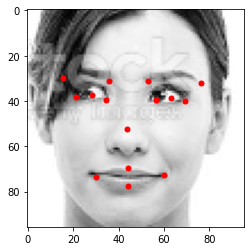

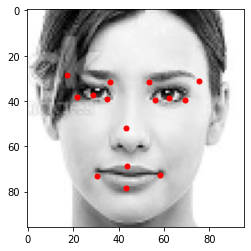

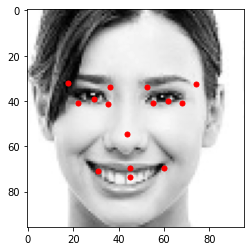

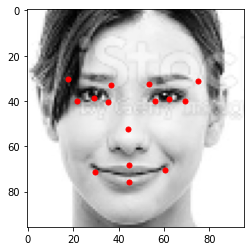

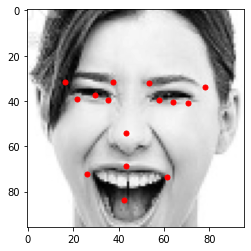

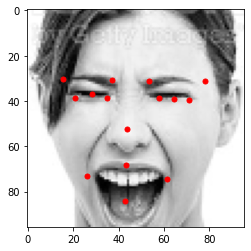

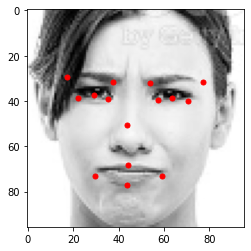

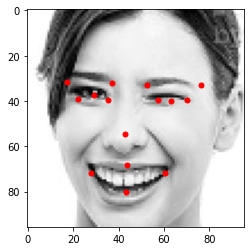

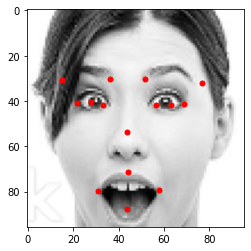

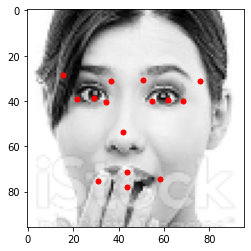

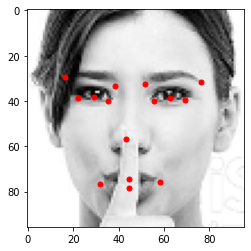

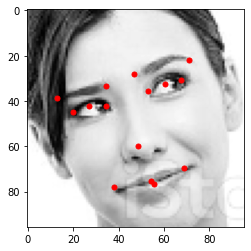

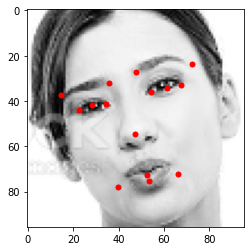

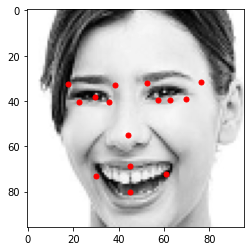

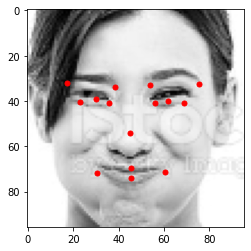

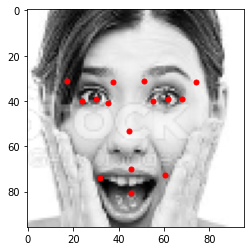

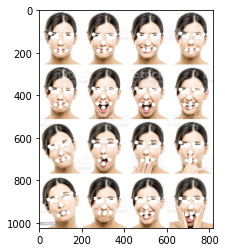

In [ ]:
#####  TEST YOUR IMAGE FILE WITH THE MODEL  #####


import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

# Load the saved model
from keras.models import load_model
model = load_model('model1.h5')  # <-- Saved model path


def detect_points(face_img):
    me  = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48 
    
    return label_points
    
# Load haarcascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
dimensions = (96, 96)

# Enter the path to your test image
img = cv2.imread('/content/multi_face.jpg')

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
# faces = face_cascade.detectMultiScale(gray_img, 4, 6)

faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False


all_x_cords = []
all_y_cords = []

for i, (x,y,w,h) in enumerate(faces):
    
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)
    
    scale_val_x = w/96
    scale_val_y = h/96
    
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)
   
   
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
    plt.show()
    
    
plt.imshow(default_img)    
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()


